### Imports

In [ ]:
import pandas as pd
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import vre_repository_connector as vrc
import joblib 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle

# MERGING

In [ ]:
# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/nfl-stadium-attendance-dataset")

# Load the dataframe from the file
def load_data(name):
    return pd.read_csv(f"{path}/{name}")

attendance_df = load_data("attendance.csv")
standings_df = load_data("standings.csv")
games_df = load_data("games.csv")

##### BACKUP GITHUB STORAGE #####

# attendance_df.to_csv('data/attendance.csv')
# standings_df.to_csv('data/standings.csv')
# games_df.to_csv('data/games.csv')

##### Kaggle 404 ? #####

# attendance_df = pd.read_csv('data/attendance.csv')
#standings_df = pd.read_csv('data/standings.csv')
#games_df = pd.read_csv('data/games.csv')

##### BACKUP GITHUB STORAGE #####

attendance_weekly_df = attendance_df[['team', 'team_name', 'year', 'week', 'weekly_attendance']]

attendance_df = attendance_df.drop(columns=['weekly_attendance'])

### ATTENDANCE
# year was shitted by one year, so that last years standings will have influence on attendance
attendance_df['year'] = attendance_df['year'] + 1

attendance_df = attendance_df.merge(attendance_weekly_df, on=['team', 'team_name', 'year', 'week'], how='left')


### STANDINGS
# similar like above for standings
standings_df['year'] = standings_df['year'] + 1

attendance_standings_df = pd.merge(attendance_df, standings_df, on=['team', 'team_name', 'year'])

attendance_standings_df['team_name'] = attendance_standings_df['team'] + ' ' + attendance_standings_df['team_name']

### GAMES
games_df = games_df[games_df['week'].str.isnumeric()]
games_df['week'] = games_df['week'].astype(int)

### MERGE

df1 = attendance_standings_df.merge(games_df, left_on=['year', 'week', 'team_name'], right_on=['year', 'week', 'home_team'], how='inner')
df2 = attendance_standings_df.merge(games_df, left_on=['year', 'week', 'team_name'], right_on=['year', 'week', 'away_team'], how='inner')

df = df1.merge(df2, on=['year', 'week', 'home_team', 'away_team'], how='inner', suffixes=('_home', '_away'))

df = df.drop(columns=['home_team', 'away_team', 'weekly_attendance_away', 'team_away'])
df = df.rename(columns={'team_home': 'city'})

In [ ]:
# df.to_csv("data/merged_unprocessed.csv", index=False)

# PREPROCESS

In [27]:
duplicated_columns = ['winner', 'tie', 'day', 'date', 'time', 'pts_win', 'pts_loss', 'yds_win', 'turnovers_win', 'yds_loss', 'turnovers_loss', 'home_team_name', 'home_team_city', 'away_team_name', 'away_team_city', 'loss']
duplicated_columns_away = list(map(lambda x: x + '_away', duplicated_columns))
duplicated_columns_home = list(map(lambda x: x + '_home', duplicated_columns))

duplicated_columns_mapping = dict(zip(duplicated_columns_home, duplicated_columns))

df = df.drop(columns=duplicated_columns_away)
df = df.rename(columns=duplicated_columns_mapping)

columns_to_drop = ['total_home', 'away_home', 'date', 'time', 'city']

columns_to_rename = {
    'home_home': 'home_attendance_last_year_home',
    'away_home': 'away_attendance_last_year_home',
    'home_away': 'home_attendance_last_year_away',
    'away_away': 'away_attendance_last_year_away',
}

df = df.drop(columns=columns_to_drop)
df = df.rename(columns=columns_to_rename)
df = df.replace({ 'Playoffs': 1, 'No Playoffs': 0, 'Won Superbowl': 1, 'No Superbowl': 0 })

df[['playoffs_away', 'sb_winner_away', 'playoffs_home', 'sb_winner_home']] = df[['playoffs_away', 'sb_winner_away', 'playoffs_home', 'sb_winner_home']].astype(int)


season_stats_df = pd.DataFrame(columns=['year', 'week', 'team_name', 'points', 'yards', 'turnovers', 'win', 'loss', 'tie'], dtype=int)
season_stats_df['team_name'] = season_stats_df['team_name'].astype(str)

for index, row in df.iterrows():
    winning_team = row['winner']    
    losing_team = row['team_name_away'] if winning_team == row['team_name_home'] else row['team_name_home']

    for team in [winning_team, losing_team]:
        season_stats_df.loc[len(season_stats_df)] = {
            'year': row['year'],
            'week': row['week'],
            'team_name': team,
            'points': row['pts_win'] if team == winning_team else row['pts_loss'],
            'yards': row['yds_win'] if team == winning_team else row['yds_loss'],
            'turnovers': row['turnovers_win'] if team == winning_team else row['turnovers_loss'],
            'win': 1 if team == winning_team and pd.isna(row['tie']) else 0,
            'loss': 1 if team == losing_team and pd.isna(row['tie']) else 0,
            'tie': 1 if not pd.isna(row['tie'])  else 0
        }

min_year = season_stats_df['year'].min()
max_year = season_stats_df['year'].max()
teams = season_stats_df['team_name'].unique()

# Fill in missing weeks with 0s
for team in teams:
    for year in range(min_year, max_year + 1):
        for week in range(1, 18):
            if len(season_stats_df[(season_stats_df['team_name'] == team) & (season_stats_df['year'] == year) & (season_stats_df['week'] == week)]) == 0:
                season_stats_df.loc[len(season_stats_df)] = {
                    'year': year,
                    'week': week,
                    'team_name': team,
                    'points': 0,
                    'yards': 0,
                    'turnovers': 0,
                    'win': 0,
                    'loss': 0,
                    'tie': 0
                }


# Group by years, and calculate running totals
season_stats_df = season_stats_df.sort_values(by=['team_name', 'year', 'week'])
season_stats_df['points'] = season_stats_df['points'].astype(int)
season_stats_df['yards'] = season_stats_df['yards'].astype(int)
season_stats_df['turnovers'] = season_stats_df['turnovers'].astype(int)
season_stats_df['win'] = season_stats_df['win'].astype(int)
season_stats_df['loss'] = season_stats_df['loss'].astype(int)
season_stats_df['tie'] = season_stats_df['tie'].astype(int)

season_stats_df['points'] = season_stats_df.groupby(['team_name', 'year'])['points'].cumsum()
season_stats_df['yards'] = season_stats_df.groupby(['team_name', 'year'])['yards'].cumsum()
season_stats_df['turnovers'] = season_stats_df.groupby(['team_name', 'year'])['turnovers'].cumsum()
season_stats_df['win'] = season_stats_df.groupby(['team_name', 'year'])['win'].cumsum()
season_stats_df['loss'] = season_stats_df.groupby(['team_name', 'year'])['loss'].cumsum()
season_stats_df['tie'] = season_stats_df.groupby(['team_name', 'year'])['tie'].cumsum()


season_stats_df['week'] = season_stats_df['week'] + 1
# season_stats_df = season_stats_df[season_stats_df['week'] <= 17]

for index, row in season_stats_df[season_stats_df['week'] == 18].iterrows():
    season_stats_df.loc[index] = {
        'year': row['year'],
        'week': 1,
        'team_name': row['team_name'],
        'points': 0,
        'yards': 0,
        'turnovers': 0,
        'win': 0,
        'loss': 0,
        'tie': 0
    }

season_stats_df = season_stats_df.sort_values(by=['team_name', 'year', 'week'])
season_stats_df[(season_stats_df['team_name'] == 'Arizona Cardinals')][season_stats_df['year'] == 2019]
games_columns_to_delete = ['winner', 'tie', 'day', 'pts_win', 'pts_loss', 'yds_win', 'turnovers_win', 'yds_loss', 'turnovers_loss', 'home_team_name', 'home_team_city', 'away_team_name', 'away_team_city']
df = df.drop(columns=games_columns_to_delete)

season_stats_df = season_stats_df.rename(columns={ 'team_name': 'team_name_home' })
df = df.merge(season_stats_df, on=['team_name_home', 'year', 'week'], how='inner', suffixes=['', '_home'])

season_stats_df = season_stats_df.rename(columns={ 'team_name_home': 'team_name_away' })
df = df.merge(season_stats_df, on=['team_name_away', 'year', 'week'], how='inner', suffixes=['', '_away'])

/var/folders/db/djqfj81d1vs_17ntzp2n867m0000gn/T/ipykernel_79476/315123936.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({ 'Playoffs': 1, 'No Playoffs': 0, 'Won Superbowl': 1, 'No Superbowl': 0 })
/var/folders/db/djqfj81d1vs_17ntzp2n867m0000gn/T/ipykernel_79476/315123936.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  season_stats_df[(season_stats_df['team_name'] == 'Arizona Cardinals')][season_stats_df['year'] == 2019]


### Dataset Description

The table below describes the columns resulting from the merging and preprocessing of NFL game data. These features will be used to train a Random Forest regressor to predict home game attendance.

| Column Name                    | Description                                                                 |
|-------------------------------|-----------------------------------------------------------------------------|
| `team_name_home`              | Name of the home team                                                       |
| `team_name_away`              | Name of the away team                                                       |
| `year`                        | Year the game was played                                                    |
| `week`                        | Week of the season (1–17 regular season)                                    |
| `weekly_attendance_home`      | **Target variable** – Number of attendees at the home game                  |
| `points_for_home`             | Total points scored by the home team throughout the season                  |
| `points_against_home`         | Total points allowed by the home team throughout the season                 |
| `points_differential_home`    | Point difference for the home team across the season                        |
| `simple_rating_home`          | Home team's overall performance rating, factoring in strength of schedule  |
| `margin_of_victory_home`      | Average margin of victory for the home team                                 |
| `wins_home`                   | Total wins by the home team                                                 |
| `offensive_ranking_home`      | Offensive performance rank of the home team                                 |
| `defensive_ranking_home`      | Defensive performance rank of the home team                                 |
| `points_for_away`             | Total points scored by the away team throughout the season                  |
| `points_against_away`         | Total points allowed by the away team throughout the season                 |
| `points_differential_away`    | Point difference for the away team across the season                        |
| `simple_rating_away`          | Away team's overall performance rating                                      |
| `wins_away`                   | Total wins by the away team                                                 |
| `offensive_ranking_away`      | Offensive performance rank of the away team                                 |
| `defensive_ranking_away`      | Defensive performance rank of the away team                                 |

**Note**: Points and performance stats are aggregated across the season for both home and away teams. These variables are useful in understanding the potential drivers of attendance trends.


## Creating Attendance IDs for Splitting the Data into Train, Validation and Test for DBRepo

In [111]:
df = df.sample(frac=1, random_state=12335272).reset_index(drop=True)


df['attendance_id'] = df.index


cols = ['attendance_id'] + [col for col in df.columns if col != 'attendance_id']
df = df[cols]


In [ ]:
#df.to_csv('data/merged_preprocessed.csv', index=False)

In [30]:
from dbrepo.RestClient import RestClient
from dotenv import load_dotenv
import os

load_dotenv() 
password = os.getenv("DBREPO_PASSWORD")

client = RestClient(
    endpoint="https://test.dbrepo.tuwien.ac.at",
    username="emilp-tuwien",
    password=password
)
training = client.get_identifier_data(identifier_id="56171866-21d8-4b89-a44c-a3044bf2d43d")
validation = client.get_identifier_data(identifier_id="e336829d-fefb-4a09-95f9-0196ee3fc194")
test =  client.get_identifier_data(identifier_id="a8b213d1-c66b-417d-8fc0-aa2bb9393ad2")


In [ ]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3365 entries, 0 to 3364
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   attendance_id                   3365 non-null   object
 1   team_name_home                  3365 non-null   object
 2   year                            3365 non-null   object
 3   home_attendance_last_year_home  3365 non-null   object
 4   week                            3365 non-null   object
 5   weekly_attendance_home          3365 non-null   object
 6   wins_home                       3365 non-null   object
 7   loss                            3365 non-null   object
 8   points_for_home                 3365 non-null   object
 9   points_against_home             3365 non-null   object
 10  points_differential_home        3365 non-null   object
 11  margin_of_victory_home          3365 non-null   object
 12  strength_of_schedule_home       3365 non-null   

# Model

We can now begin building the Random Forest model, but first, the categorical features need to be one-hot encoded.

In [32]:

training = pd.get_dummies(training, columns=['team_name_home', 'team_name_away'])
validation = pd.get_dummies(validation, columns=['team_name_home', 'team_name_away'])
test = pd.get_dummies(test, columns=['team_name_home', 'team_name_away'])


Logical values have to be processed.

In [ ]:
def convert_bool_strings(df):
    return df.replace({'true': 1, 'false': 0, 'True': 1, 'False': 0})

training = convert_bool_strings(training)
validation = convert_bool_strings(validation)
test = convert_bool_strings(test)


Numerical values have to be scaled

In [ ]:
target = 'weekly_attendance_home'

# Separate features and labels
X_train, y_train = training.drop(columns=[target]), training[target]
X_val, y_val = validation.drop(columns=[target]), validation[target]
X_test, y_test = test.drop(columns=[target]), test[target]

scaler = StandardScaler()
scaler.fit(X_train)

### SCALING X 

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


### SCALING Y 
target_scaler = StandardScaler()
target_scaler.fit(y_train.values.reshape(-1, 1))

y_train_scaled = target_scaler.transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

/var/folders/db/djqfj81d1vs_17ntzp2n867m0000gn/T/ipykernel_79476/2912952260.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace({'true': 1, 'false': 0, 'True': 1, 'False': 0})


In [ ]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
vrc.upload("scaler.pkl", url="https://test.researchdata.tuwien.ac.at")

(InvenioRDM) Enter your API token for 'https://test.researchdata.tuwien.ac.at/api'


('https://test.researchdata.tuwien.ac.at', 'zmp8r-smf36', 'scaler.pkl')

In [94]:
with open("target_scaler.pkl", "wb") as f:
    pickle.dump(target_scaler, f)

In [95]:
vrc.upload("target_scaler.pkl", url="https://test.researchdata.tuwien.ac.at")

(InvenioRDM) Enter your API token for 'https://test.researchdata.tuwien.ac.at/api'


('https://test.researchdata.tuwien.ac.at', 'x7rq7-s2c72', 'target_scaler.pkl')

## Hyperparameter Tuning

In [93]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],  # Default: 100, added: 50 150 and 200 250
    'max_depth': [None, 10, 50],    # default: None, added: 10 
    'min_samples_split': [2, 5],    # default: 2, added: 5
    'min_samples_leaf': [1, 3, 7],     # default: 1, added: 3
    'max_features': [None, 'sqrt', 'log2'] # default: None, added: sqrt log2
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=12335272),
    param_grid,
    cv=3,
    n_jobs=10,
    scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train_scaled, y_train_scaled)

best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(X_val_scaled)

y_val_pred_orig = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
y_val_orig = target_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_val_orig, y_val_pred_orig)
mse = mean_squared_error(y_val_orig, y_val_pred_orig)
r2 = r2_score(y_val_orig, y_val_pred_orig)


In [96]:
# Create a detailed results summary
validation_results_txt = f"""
==========================================================
     Random Forest Regressor — Validation Set Results
==========================================================

📈 Validation Set Metrics (Original Scale):
   • Mean Absolute Error (MAE): {mae:,.2f}
   • Mean Squared Error (MSE):  {mse:,.2f}
   • R² Score:                  {r2:.4f}

----------------------------------------------------------
🧠 Model Overview:
----------------------------------------------------------
• Model Type: Random Forest Regressor
• Source: sklearn.ensemble.RandomForestRegressor
• Python Version: 3.13.1
• Libraries Used: scikit-learn, pandas, numpy

• Hyperparameter Tuning:
  - Method: GridSearchCV with 3-fold cross-validation
  - Scoring: Negative Mean Absolute Error (neg_mean_absolute_error)

• Best Hyperparameters:
  - n_estimators:      {best_model.n_estimators}
  - max_depth:         {best_model.max_depth}
  - min_samples_split: {best_model.min_samples_split}
  - min_samples_leaf:  {best_model.min_samples_leaf}
  - max_features:      {best_model.max_features}

----------------------------------------------------------
📦 Dataset & Preprocessing:
----------------------------------------------------------
• Dataset: Merged NFL Stadium Attendance Dataset from Kaggle  
  ↳ https://www.kaggle.com/datasets/sujaykapadnis/nfl-stadium-attendance-dataset

• Merged Files:
  - games.csv
  - standings.csv
  - attendance.csv

• Target Variable: Weekly stadium attendance

• Preprocessing:
  - Categorical features → one-hot encoded
  - Numerical features   → scaled using StandardScaler
  - Target variable      → scaled using StandardScaler

• Data Split:
  - Training:   70%
  - Validation: 15% (used for evaluating model generalization)
  - Test:       15% (not used in this evaluation)

----------------------------------------------------------
📁 File Info:
----------------------------------------------------------
• This file: rf_validation_results.txt
• Model file: best_model.pkl
• Scalers:    scaler.pkl, target_scaler.pkl
• Notebook:   prediction.ipynb

"""

# Save to txt
with open("rf_validation_results.txt", "w") as f:
    f.write(validation_results_txt)

print("✅ Validation results saved to 'rf_validation_results.txt'")

✅ Validation results saved to 'rf_validation_results.txt'


In [97]:
vrc.upload("rf_validation_results.txt", url="https://test.researchdata.tuwien.ac.at")

(InvenioRDM) Enter your API token for 'https://test.researchdata.tuwien.ac.at/api'


('https://test.researchdata.tuwien.ac.at',
 'e3ge6-0yy80',
 'rf_validation_results.txt')

In [87]:
grid_search.best_params_

{'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 250}

In [83]:
import pickle

with open("hyp_tuning_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

vrc.upload("hyp_tuning_best_model.pkl", url="https://test.researchdata.tuwien.ac.at")


(InvenioRDM) Enter your API token for 'https://test.researchdata.tuwien.ac.at/api'


('https://test.researchdata.tuwien.ac.at',
 '9bnb9-n0c65',
 'hyp_tuning_best_model.pkl')

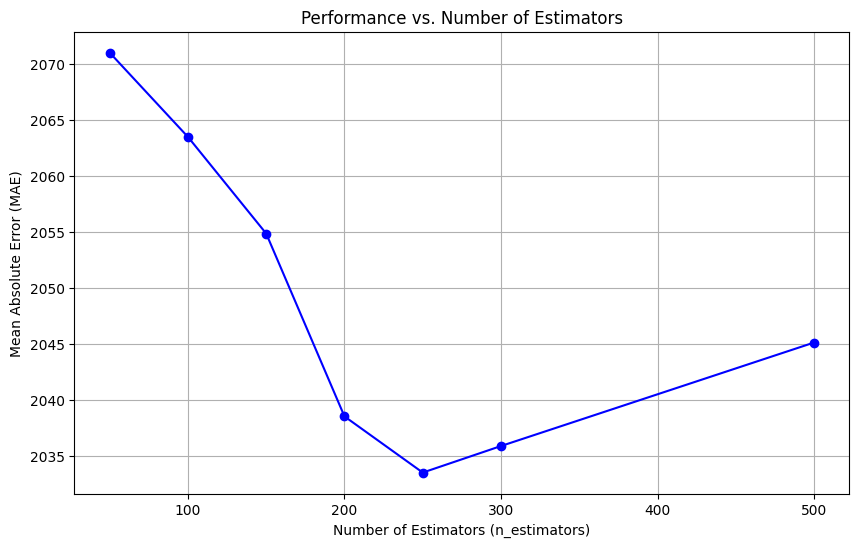

In [98]:
n_estimators_range = [50, 100, 150, 200, 250, 300, 500]

mae_scores = []

for n in n_estimators_range:
    model = RandomForestRegressor(
        n_estimators=n,
        max_depth=None, 
        min_samples_split=2,  
        min_samples_leaf=3, 
        max_features=None,
        random_state=12335272
    )
    model.fit(X_train_scaled, y_train_scaled)
    
    y_val_pred = model.predict(X_val_scaled)
    y_val_pred_orig = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
    y_val_orig = target_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
    
    mae = mean_absolute_error(y_val_orig, y_val_pred_orig)
    mae_scores.append(mae)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, mae_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Performance vs. Number of Estimators")
plt.grid()
plt.savefig("mae_vs_estimators.png", dpi=300, bbox_inches='tight')
plt.show()


In [99]:
vrc.upload("mae_vs_estimators.png", url="https://test.researchdata.tuwien.ac.at")

(InvenioRDM) Enter your API token for 'https://test.researchdata.tuwien.ac.at/api'


('https://test.researchdata.tuwien.ac.at',
 '9z39d-eze67',
 'mae_vs_estimators.png')

# Evaluation on Test Data

In [ ]:
y_test_pred = best_model.predict(X_test_scaled)

mae_test_scaled = mean_absolute_error(y_test_scaled, y_test_pred)
mse_test_scaled = mean_squared_error(y_test_scaled, y_test_pred)

y_test_pred_orig = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_orig = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_orig, y_test_pred_orig)
mse = mean_squared_error(y_test_orig, y_test_pred_orig)
r2 = r2_score(y_test_orig, y_test_pred_orig)

Test Set Performance Scaled:
MAE: 0.2179
MSE: 0.1896
Test Set Performance Unscaled:
MAE: 1914.2333
MSE: 14626303.5872
R-squared: 0.8217


In [91]:
# Formatted string for results
results_txt = f"""
==========================================================
     Random Forest Regressor — Test Set Evaluation
==========================================================

📊 Scaled Test Set Metrics:
   • Mean Absolute Error (MAE): {mae_test_scaled:.4f}
   • Mean Squared Error (MSE):  {mse_test_scaled:.4f}

📈 Unscaled Test Set Metrics (Original Scale):
   • Mean Absolute Error (MAE): {mae:,.2f}
   • Mean Squared Error (MSE):  {mse:,.2f}
   • R² Score:                  {r2:.4f}

----------------------------------------------------------
🧠 Model Overview:
----------------------------------------------------------
• Model Type: Random Forest Regressor
• Implementation: sklearn.ensemble.RandomForestRegressor
• Python Version: 3.13.1
• Libraries Used: scikit-learn, pandas, numpy, matplotlib

• Hyperparameter Tuning:
  - Method: GridSearchCV with 3-fold cross-validation
  - Scoring: Negative Mean Absolute Error (neg_mean_absolute_error)

• Best Hyperparameters:
  - n_estimators:      250
  - max_depth:         None
  - min_samples_split: 2
  - min_samples_leaf:  3
  - max_features:      None

----------------------------------------------------------
📦 Dataset & Preprocessing:
----------------------------------------------------------
• Source Dataset: NFL Stadium Attendance Dataset  
  ↳ https://www.kaggle.com/datasets/sujaykapadnis/nfl-stadium-attendance-dataset  
  ↳ Creator: Sujay Kapadnis

• Merged Files:
  - games.csv
  - standings.csv
  - attendance.csv

• Target Variable: Weekly NFL stadium attendance

• Feature Engineering:
  - Categorical features → one-hot encoded
  - Numerical features   → scaled using StandardScaler
  - Target variable      → scaled using StandardScaler (for training)

• Data Split:
  - Training:   70%
  - Validation: 15% (used in GridSearchCV for CV folds)
  - Test:       15% (used for final performance evaluation)

----------------------------------------------------------
📁 File Info:
----------------------------------------------------------
• This file: rf_test_results.txt
• Model file: best_model.pkl
• Scalers:    scaler.pkl, target_scaler.pkl
• Notebook:   prediction.ipynb (full pipeline)

"""

# Save to txt file
with open("rf_test_results.txt", "w") as f:
    f.write(results_txt)

print("✅ Descriptive results saved to 'rf_test_results.txt'")


✅ Descriptive results saved to 'rf_test_results.txt'


In [92]:
vrc.upload("rf_test_results.txt", url="https://test.researchdata.tuwien.ac.at")

(InvenioRDM) Enter your API token for 'https://test.researchdata.tuwien.ac.at/api'


('https://test.researchdata.tuwien.ac.at',
 '7reyq-53v82',
 'rf_test_results.txt')

# Uploading Figure to TUWRD

In [ ]:
#vrc.upload("mae_vs_estimators.png", url="https://test.researchdata.tuwien.ac.at")

(InvenioRDM) Enter your API token for 'https://test.researchdata.tuwien.ac.at/api'


('https://test.researchdata.tuwien.ac.at',
 't6nzg-pyp07',
 'mae_vs_estimators.png')